## **Player Shotmap**

Rafael Leão | AC Milan

In [1]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from highlight_text import fig_text
from mplsoccer import VerticalPitch
from PIL import Image
import urllib

##### **Data Retrieval**

- https://understat.readthedocs.io/en/latest/classes/understat.html#the-functions

Understat.get_player_shots(player_id, options=None, **kwargs) <br/>
_Returns the player with the given ID's shot data._

Parameters:
- player_id (int or str) - The player's Understat ID.
- options - Options to filter the data by, defaults to None.
- options - dict, optional

Returns: List of the player's shot data | Return type: list

It returns the given player's shot data, which includes information about the situation (open play, freekick etc.), if it hit the post or was a goal, and more. Basically, all the information that you can get from a player's page in the section shown below.

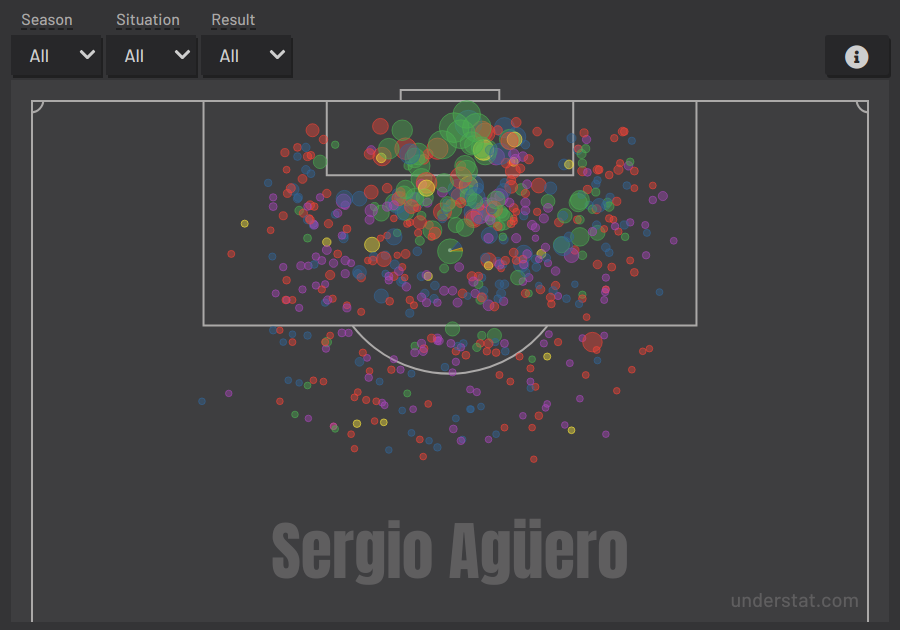

In [ ]:
import asyncio
import json
import aiohttp
from understat import Understat

- Rafael Leão | https://understat.com/player/7193

In [ ]:
async with aiohttp.ClientSession() as session:
    understat = Understat(session)
    player_shots = await understat.get_player_shots(7193)
    leao_shots = pd.DataFrame(player_shots)

In [ ]:
leao_shots

In [ ]:
# save as csv
leao_shots.to_csv('../data/leao_shots.csv', index=False)

##### **Data Preparation**

In [2]:
df_leao_shots = pd.read_csv('../data/leao_shots.csv')

In [3]:
print(df_leao_shots.shape)
print('')
print(df_leao_shots.columns)
print('')
print(df_leao_shots.dtypes)

(396, 20)

Index(['id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a', 'player_id',
       'situation', 'season', 'shotType', 'match_id', 'h_team', 'a_team',
       'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction'],
      dtype='object')

id                   int64
minute               int64
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int64
situation           object
season               int64
shotType            object
match_id             int64
h_team              object
a_team              object
h_goals              int64
a_goals              int64
date                object
player_assisted     object
lastAction          object
dtype: object


In [4]:
columns_to_convert = ['id', 'minute', 'X', 'Y', 'xG', 'player_id', 'season', 'match_id', 'h_goals', 'a_goals']

# convert columns to numeric
df_leao_shots[columns_to_convert] = df_leao_shots[columns_to_convert].apply(pd.to_numeric, errors='coerce', downcast='integer')

In [5]:
df_leao_shots.dtypes

id                   int32
minute                int8
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int16
situation           object
season               int16
shotType            object
match_id             int16
h_team              object
a_team              object
h_goals               int8
a_goals               int8
date                object
player_assisted     object
lastAction          object
dtype: object

In X and Y columns, data are scaled between 0 and 1. To make it work with a football pitch, we need them scaled between 0 and 100.

In [6]:
df_leao_shots['X'] = df_leao_shots['X'] * 100
df_leao_shots['Y'] = df_leao_shots['Y'] * 100

In [7]:
df_leao_shots.isnull().sum()

id                  0
minute              0
result              0
X                   0
Y                   0
xG                  0
player              0
h_a                 0
player_id           0
situation           0
season              0
shotType            0
match_id            0
h_team              0
a_team              0
h_goals             0
a_goals             0
date                0
player_assisted    56
lastAction         32
dtype: int64

In [8]:
# filter for desired season
df_leao_shots = df_leao_shots[df_leao_shots['season'] == 2023]
print(df_leao_shots.shape)

(70, 20)


In [9]:
df_leao_shots.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
314,534191,28,BlockedShot,95.300003,60.400002,0.103951,Rafael Leão,a,7193,FromCorner,2023,RightFoot,22314,Bologna,AC Milan,0,2,2023-08-21 18:45:00,Ruben Loftus-Cheek,Rebound
315,534204,89,BlockedShot,91.300003,67.599998,0.260818,Rafael Leão,a,7193,OpenPlay,2023,LeftFoot,22314,Bologna,AC Milan,0,2,2023-08-21 18:45:00,Rade Krunic,Pass
316,535044,4,SavedShot,79.199997,75.000000,0.010110,Rafael Leão,h,7193,OpenPlay,2023,RightFoot,22317,AC Milan,Torino,4,1,2023-08-26 18:45:00,Olivier Giroud,Chipped
317,535051,23,MissedShots,76.500000,56.900002,0.023786,Rafael Leão,h,7193,OpenPlay,2023,LeftFoot,22317,AC Milan,Torino,4,1,2023-08-26 18:45:00,NaN,NaN
318,535841,27,BlockedShot,84.900002,76.099998,0.087903,Rafael Leão,a,7193,OpenPlay,2023,RightFoot,22326,Roma,AC Milan,1,2,2023-09-01 18:45:00,Malick Thiaw,Chipped


##### **Data Modeling**

In [10]:
# calculate the stats to display
# 1. Total shots
# 2. Total goals
# 3. Total xG
# 4. xG per shot
# 5. Average distance of shots

leao_total_shots = df_leao_shots.shape[0]
leao_total_goals = df_leao_shots[df_leao_shots['result'] == 'Goal'].shape[0]
leao_total_xG = df_leao_shots['xG'].sum()
leao_xG_per_shot = leao_total_xG / leao_total_shots
leao_points_average_distance = df_leao_shots['X'].mean()
leao_actual_average_distance = 120 - (df_leao_shots['X'] * 1.2).mean()
print(leao_points_average_distance, leao_actual_average_distance)

86.1014289855957 16.678285217285165


##### **Data Visualization**

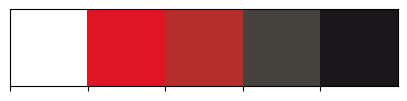

In [11]:
import seaborn as sns
acm = ['#FFFFFF','#E11624', '#B52E2B', '#46433F', '#1A161A']
sns.palplot(sns.color_palette(acm))

In [12]:
pitch = VerticalPitch(
    pitch_type='opta',
    half=True,
    pad_bottom=.5,
    line_color='black',
    linewidth=1.5,
    axis=True, label=True
)

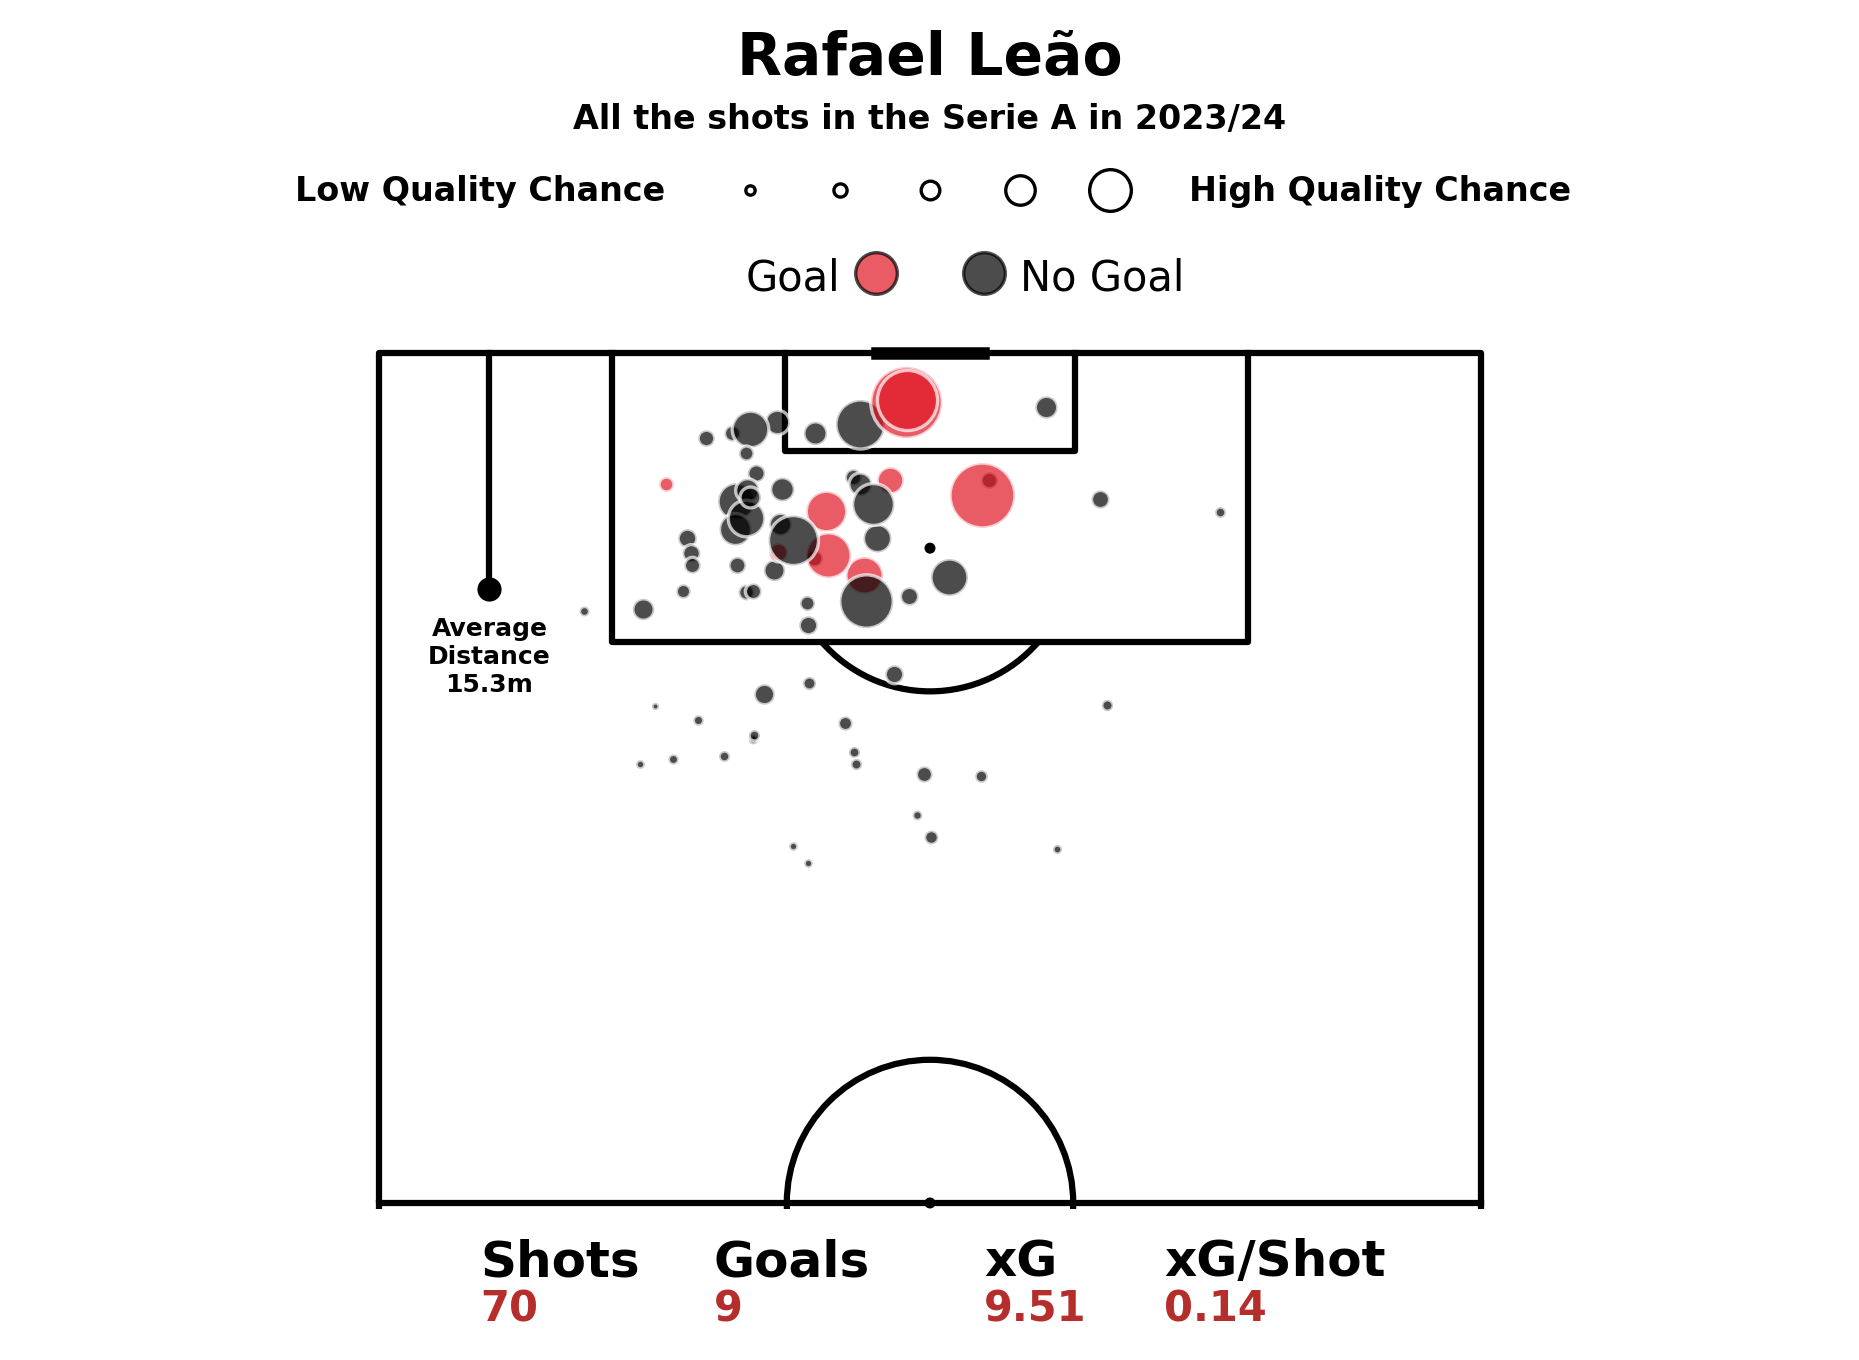

In [13]:
# function to simplify adding text
def add_text(ax, x, y, s, fontsize, color='black', ha='center', fontweight=None):
    ax.text(x, y, s, fontsize=fontsize, color=color, ha=ha, fontweight=fontweight)

# function to simplify adding scatter points
def add_scatter(ax, x, y, s, color='white', edgecolor='black', linewidth=.8, alpha=1):
    ax.scatter(x, y, s=s, color=color, edgecolor=edgecolor, linewidth=linewidth, alpha=alpha)

# create figure and axes
fig = plt.figure(figsize=(6, 6), dpi=300)

# first axis for titles and categories
ax1 = fig.add_axes([0, 0.7, 1, 0.2])
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_axis_off()

# titles
add_text(ax1, x=0.5, y=.9, s='Rafael Leão', fontsize=14, fontweight='bold')
add_text(ax1, x=0.5, y=.75, s='All the shots in the Serie A in 2023/24', fontsize=8, fontweight='bold')

# low and high quality labels with scatter points
add_text(ax1, x=0.25, y=0.55, s='Low Quality Chance', fontsize=8, fontweight='bold')
add_text(ax1, x=0.75, y=0.55, s='High Quality Chance', fontsize=8, fontweight='bold')

# scatter points representing chance quality
scatter_sizes = [5, 10, 20, 50, 100]
scatter_x_positions = [0.4, 0.45, 0.5, 0.55, 0.6]
for x, size in zip(scatter_x_positions, scatter_sizes):
    add_scatter(ax1, x=x, y=0.58, s=size)

# goal and no goal labels with corresponding scatter points
add_text(ax1, x=0.45, y=0.3, s='Goal', fontsize=10, ha='right')
add_scatter(ax1, x=0.47, y=0.35, s=100, color='#E11624', alpha=0.7)
add_scatter(ax1, x=0.53, y=0.35, s=100, color='black', alpha=0.7)
add_text(ax1, x=0.55, y=0.3, s='No Goal', fontsize=10, ha='left')

# second axis for pitch
ax2 = fig.add_axes([.05, 0.25, .9, .5])
pitch.draw(ax=ax2)

# plot the average distance
# convert the average distance from yards to meters (1 yard = 0.9144 meters)
add_scatter(ax2, x=90, y=leao_points_average_distance, color='black', s=25)
ax2.plot([90, 90], [100, leao_points_average_distance], color='black', linewidth=1.5)
leao_actual_average_distance = leao_actual_average_distance * 0.9144
add_text(ax2, x=90, y=leao_points_average_distance - 6, s=f'Average\nDistance\n{leao_actual_average_distance:.1f}m', fontsize=6, fontweight='bold')

# plot the shots
for shot in df_leao_shots.to_dict(orient='records'):
    pitch.scatter(
        shot['X'], 
        shot['Y'], 
        s=300 * shot['xG'], 
        color='#E11624' if shot['result'] == 'Goal' else 'black', 
        ax=ax2,
        alpha=.7,
        linewidth=.8,
        edgecolor='white'
    )

ax2.set_axis_off()

# third axis for stats
ax3 = fig.add_axes([0, .2, 1, .05])
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_axis_off()

# stats labels and values
stats = [
    ('Shots', leao_total_shots),
    ('Goals', leao_total_goals),
    ('xG', f'{leao_total_xG:.2f}'),
    ('xG/Shot', f'{leao_xG_per_shot:.2f}')
]
x_positions = [0.25, 0.38, 0.53, 0.63]
for (label, value), x in zip(stats, x_positions):
    add_text(ax3, x=x, y=.25, s=label, fontsize=12, fontweight='bold', ha='left')
    add_text(ax3, x=x, y=-0.25, s=f'{value}', fontsize=10, fontweight='bold', color='#B52E2B', ha='left')

plt.savefig(
    '../figures/leao-shots_23-24.png',
    dpi=300,
    facecolor = "white",
    bbox_inches='tight',
    edgecolor="none"
)

In [14]:
# scrape Fotmob's website and plot the image directly into the visual
# create a new axes object to draw the image
fotmob_url = "https://images.fotmob.com/image_resources/playerimages/"

logo_ax = fig.add_axes([0.75, .95, 0.15, 0.15], zorder=1)
icon = Image.open(urllib.request.urlopen(f"{fotmob_url}848844.png"))
logo_ax.imshow(icon)
logo_ax.axis("off")

(-0.5, 191.5, 191.5, -0.5)